In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from kmodes.kprototypes import KPrototypes

import matplotlib.pyplot as plt
import seaborn as sns
import joblib
%matplotlib inline

In [2]:
df_tri = pd.read_csv('Data/df_tri.csv')
df_rtds = pd.read_csv('Data/df_rtds.csv')
df_rtdu = pd.read_csv('Data/df_rtdu.csv')

In [3]:
df_mm = pd.read_csv('Data/SharedResponses.csv', chunksize=100_000, dtype=str, low_memory=False)

cleaned_chunks = []
for i, chunk in enumerate(df_mm):
    print(f"Processing chunk {i+1}")

    # Cleaning
    chunk_cleaned = chunk[chunk['ScenarioTypeStrict'] == 'Utilitarian']
    chunk_cleaned = chunk_cleaned.drop(columns=['ScenarioOrder', 'Intervention', 'ScenarioType', 'DefaultChoice', 'NonDefaultChoice', 'DefaultChoiceIsOmission', 'Template','DescriptionShown','LeftHand'])
    chunk_cleaned.rename(columns={'UserCountry3': 'Country'}, inplace=True)
    chunk_cleaned = chunk_cleaned.dropna()
    chunk_cleaned = chunk_cleaned.drop_duplicates()
    chunk_cleaned = chunk_cleaned.merge(df_tri, on='Country', how='inner').merge(df_rtds, on='Country', how='inner').merge(df_rtdu, on='Country', how='inner')
    chunk_cleaned[['ResponseID', 'ExtendedSessionID', 'UserID', 'AttributeLevel','ScenarioTypeStrict']] = chunk_cleaned[['ResponseID', 'ExtendedSessionID', 'UserID', 'AttributeLevel','ScenarioTypeStrict']].astype(str)
    chunk_cleaned[["PedPed", "Barrier", "CrossingSignal", "NumberOfCharacters", "DiffNumberOFCharacters", "Man", "Woman", "Pregnant", "Stroller", "OldMan", "OldWoman", "Boy", "Girl", "Homeless", "LargeWoman", "LargeMan", "Criminal", "MaleExecutive", "FemaleExecutive", "FemaleAthlete", "MaleAthlete", "FemaleDoctor", "MaleDoctor", "Dog", "Cat", "Saved"]] = chunk_cleaned[["PedPed", "Barrier", "CrossingSignal", "NumberOfCharacters", "DiffNumberOFCharacters", "Man", "Woman", "Pregnant", "Stroller", "OldMan", "OldWoman", "Boy", "Girl", "Homeless", "LargeWoman", "LargeMan", "Criminal", "MaleExecutive", "FemaleExecutive", "FemaleAthlete", "MaleAthlete", "FemaleDoctor", "MaleDoctor", "Dog", "Cat", "Saved"]].astype(float).round().astype('int8')
    chunk_cleaned[["Finance_access", "ICT", "Industry_activity", "Overall_index", "Research_and_development", "Skills", "Total", "Males", "Females", "Passengers", "Pedestrians"]] = chunk_cleaned[["Finance_access", "ICT", "Industry_activity", "Overall_index", "Research_and_development", "Skills", "Total", "Males", "Females", "Passengers", "Pedestrians"]].astype('float32')

    # Append cleaned chunk
    cleaned_chunks.append(chunk_cleaned)
    print(f"Finished processing chunk {i+1}")

print("All chunks have been processed")

Processing chunk 1
Finished processing chunk 1
Processing chunk 2
Finished processing chunk 2
Processing chunk 3
Finished processing chunk 3
Processing chunk 4
Finished processing chunk 4
Processing chunk 5
Finished processing chunk 5
Processing chunk 6
Finished processing chunk 6
Processing chunk 7
Finished processing chunk 7
Processing chunk 8
Finished processing chunk 8
Processing chunk 9
Finished processing chunk 9
Processing chunk 10
Finished processing chunk 10
Processing chunk 11
Finished processing chunk 11
Processing chunk 12
Finished processing chunk 12
Processing chunk 13
Finished processing chunk 13
Processing chunk 14
Finished processing chunk 14
Processing chunk 15
Finished processing chunk 15
Processing chunk 16
Finished processing chunk 16
Processing chunk 17
Finished processing chunk 17
Processing chunk 18
Finished processing chunk 18
Processing chunk 19
Finished processing chunk 19
Processing chunk 20
Finished processing chunk 20
Processing chunk 21
Finished processin

In [4]:
df = pd.concat(cleaned_chunks, ignore_index=True)

In [5]:
responseid_counts = df['ResponseID'].value_counts()
responseid_to_keep = responseid_counts[responseid_counts == 2].index
df = df[df['ResponseID'].isin(responseid_to_keep)]

In [6]:
print(df.shape[0])

10803752


In [7]:
# Randomly select 702617 unique ResponseIDs and keep only those
np.random.seed(42)
responseids = np.random.choice(df['ResponseID'].unique(), 702617, replace=False)
df = df[df['ResponseID'].isin(responseids)]

In [8]:
print(df.shape[0])

1405234


In [9]:
# Change the datatypes to reduce memory usage
df[['ResponseID', 'ExtendedSessionID', 'UserID', 'AttributeLevel','ScenarioTypeStrict']] = df[['ResponseID', 'ExtendedSessionID', 'UserID', 'AttributeLevel','ScenarioTypeStrict']].astype(str)
df[["PedPed", "Barrier", "CrossingSignal", "NumberOfCharacters", "DiffNumberOFCharacters", "Man", "Woman", "Pregnant", "Stroller", "OldMan", "OldWoman", "Boy", "Girl", "Homeless", "LargeWoman", "LargeMan", "Criminal", "MaleExecutive", "FemaleExecutive", "FemaleAthlete", "MaleAthlete", "FemaleDoctor", "MaleDoctor", "Dog", "Cat", "Saved"]] = df[["PedPed", "Barrier", "CrossingSignal", "NumberOfCharacters", "DiffNumberOFCharacters", "Man", "Woman", "Pregnant", "Stroller", "OldMan", "OldWoman", "Boy", "Girl", "Homeless", "LargeWoman", "LargeMan", "Criminal", "MaleExecutive", "FemaleExecutive", "FemaleAthlete", "MaleAthlete", "FemaleDoctor", "MaleDoctor", "Dog", "Cat", "Saved"]].astype(float).round().astype('int8')
df[["Finance_access", "ICT", "Industry_activity", "Overall_index", "Research_and_development", "Skills", "Total", "Males", "Females", "Passengers", "Pedestrians"]] = df[["Finance_access", "ICT", "Industry_activity", "Overall_index", "Research_and_development", "Skills", "Total", "Males", "Females", "Passengers", "Pedestrians"]].astype('float32')

In [10]:
pd.set_option('display.max_columns', None)
df.head()

,ResponseID,ExtendedSessionID,UserID,PedPed,Barrier,CrossingSignal,AttributeLevel,ScenarioTypeStrict,NumberOfCharacters,DiffNumberOFCharacters,Saved,Country,Man,Woman,Pregnant,Stroller,OldMan,OldWoman,Boy,Girl,Homeless,LargeWoman,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat,Finance_access,ICT,Industry_activity,Overall_index,Research_and_development,Skills,Total,Males,Females,Passengers,Pedestrians
3,2228EQY3XnmTh3dq8,-1700464608_947225429117679.0,947225429117679,0,0,0,More,Utilitarian,5,4,1,EGY,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0.5,0.30,0.6,0.45,0.35,0.50,10.75,15.45,5.95,4.4198,2.6362
8,222Ds6jjncKAX9NKZ,-354275885_3396484959539468.0,3396484959539470,1,0,2,More,Utilitarian,5,3,1,AUT,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0.8,0.70,0.8,0.80,0.60,0.70,5.45,7.95,3.00,2.2776,0.8788
11,222JKmBZudkhxWTPT,-274259431_2801963307.0,2801963307,1,0,0,Less,Utilitarian,3,2,0,USA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0.9,0.65,0.8,1.00,1.00,0.75,12.50,17.85,7.25,3.9603,1.9737
15,222Nz4x7Gz7BhYzd3,2085856881_2465676825.0,2465676825,0,0,2,More,Utilitarian,5,2,1,USA,0,1,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0.9,0.65,0.8,1.00,1.00,0.75,12.50,17.85,7.25,3.9603,1.9737
28,222qpJb6N2aRZj3fG,1625839281_587778947,587778947,0,1,0,Less,Utilitarian,3,2,0,ITA,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0.8,0.60,0.8,0.80,0.70,0.65,5.70,9.15,2.45,2.3540,0.9680


In [11]:
# Get the number of unique values ResponseID
df['ResponseID'].nunique()

702617

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1405234 entries, 3 to 10803750
Data columns (total 43 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ResponseID                1405234 non-null  object 
 1   ExtendedSessionID         1405234 non-null  object 
 2   UserID                    1405234 non-null  object 
 3   PedPed                    1405234 non-null  int8   
 4   Barrier                   1405234 non-null  int8   
 5   CrossingSignal            1405234 non-null  int8   
 6   AttributeLevel            1405234 non-null  object 
 7   ScenarioTypeStrict        1405234 non-null  object 
 8   NumberOfCharacters        1405234 non-null  int8   
 9   DiffNumberOFCharacters    1405234 non-null  int8   
 10  Saved                     1405234 non-null  int8   
 11  Country                   1405234 non-null  object 
 12  Man                       1405234 non-null  int8   
 13  Woman                     14052

In [13]:
df_less = df[df['AttributeLevel'] == "Less"]

# Keep only the rows where 'AttributeLevel' is More and the column 'ResponseID' and 'NumberOfCharacters'
df_more_less = df[df['AttributeLevel'] == "More"][['ResponseID', 'NumberOfCharacters']]

df_less.head()
#df_more_less.head()

,ResponseID,ExtendedSessionID,UserID,PedPed,Barrier,CrossingSignal,AttributeLevel,ScenarioTypeStrict,NumberOfCharacters,DiffNumberOFCharacters,Saved,Country,Man,Woman,Pregnant,Stroller,OldMan,OldWoman,Boy,Girl,Homeless,LargeWoman,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat,Finance_access,ICT,Industry_activity,Overall_index,Research_and_development,Skills,Total,Males,Females,Passengers,Pedestrians
11,222JKmBZudkhxWTPT,-274259431_2801963307.0,2801963307,1,0,0,Less,Utilitarian,3,2,0,USA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0.9,0.65,0.80,1.00,1.0,0.75,12.50,17.85,7.25,3.9603,1.9737
28,222qpJb6N2aRZj3fG,1625839281_587778947,587778947,0,1,0,Less,Utilitarian,3,2,0,ITA,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0.8,0.60,0.80,0.80,0.7,0.65,5.70,9.15,2.45,2.3540,0.9680
29,222spzyd5dNDPzy7p,1350681799_7919589696722148.0,7919589696722150,0,0,0,Less,Utilitarian,3,2,1,JPN,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.9,0.80,0.85,0.90,0.8,0.55,4.15,5.75,2.60,1.3284,1.4350
38,2232vWdTbkDr7W899,-641746212_1178865556,1178865556,1,0,1,Less,Utilitarian,2,3,0,USA,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.9,0.65,0.80,1.00,1.0,0.75,12.50,17.85,7.25,3.9603,1.9737
67,223zc9hDtTpYQhKyB,1633058270_8107644360887353.0,8107644360887350,0,0,0,Less,Utilitarian,3,2,1,SGP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0.9,1.00,0.90,0.95,0.6,0.85,2.85,4.30,1.25,1.3554,0.7857


In [14]:
# Merge the df_less and df_more_less dataframes on the 'ResponseID' column
df_merged_less = pd.merge(df_less, df_more_less, on='ResponseID')

# Create a new column 'Difference' that is the difference between the 'NumberOfCharacters_x' and 'NumberOfCharacters_y' columns
df_merged_less['NumberOfLivesSaved'] = df_merged_less['NumberOfCharacters_x'] - df_merged_less['NumberOfCharacters_y']

# Delete the 'NumberOfCharacters_y' column
df_merged_less = df_merged_less.drop(columns=['NumberOfCharacters_y'])

df_merged_less.head()

,ResponseID,ExtendedSessionID,UserID,PedPed,Barrier,CrossingSignal,AttributeLevel,ScenarioTypeStrict,NumberOfCharacters_x,DiffNumberOFCharacters,Saved,Country,Man,Woman,Pregnant,Stroller,OldMan,OldWoman,Boy,Girl,Homeless,LargeWoman,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat,Finance_access,ICT,Industry_activity,Overall_index,Research_and_development,Skills,Total,Males,Females,Passengers,Pedestrians,NumberOfLivesSaved
0,222JKmBZudkhxWTPT,-274259431_2801963307.0,2801963307,1,0,0,Less,Utilitarian,3,2,0,USA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0.9,0.65,0.80,1.00,1.0,0.75,12.50,17.85,7.25,3.9603,1.9737,-2
1,222qpJb6N2aRZj3fG,1625839281_587778947,587778947,0,1,0,Less,Utilitarian,3,2,0,ITA,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0.8,0.60,0.80,0.80,0.7,0.65,5.70,9.15,2.45,2.3540,0.9680,-2
2,222spzyd5dNDPzy7p,1350681799_7919589696722148.0,7919589696722150,0,0,0,Less,Utilitarian,3,2,1,JPN,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.9,0.80,0.85,0.90,0.8,0.55,4.15,5.75,2.60,1.3284,1.4350,-2
3,2232vWdTbkDr7W899,-641746212_1178865556,1178865556,1,0,1,Less,Utilitarian,2,3,0,USA,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.9,0.65,0.80,1.00,1.0,0.75,12.50,17.85,7.25,3.9603,1.9737,-3
4,223zc9hDtTpYQhKyB,1633058270_8107644360887353.0,8107644360887350,0,0,0,Less,Utilitarian,3,2,1,SGP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0.9,1.00,0.90,0.95,0.6,0.85,2.85,4.30,1.25,1.3554,0.7857,-2


In [15]:
df_more = df[df['AttributeLevel'] == "More"]

# Keep only the rows where 'AttributeLevel' is More and the column 'ResponseID' and 'NumberOfCharacters'
df_less_more = df[df['AttributeLevel'] == "Less"][['ResponseID', 'NumberOfCharacters']]

df_less_more.head()

,ResponseID,NumberOfCharacters
11,222JKmBZudkhxWTPT,3
28,222qpJb6N2aRZj3fG,3
29,222spzyd5dNDPzy7p,3
38,2232vWdTbkDr7W899,2
67,223zc9hDtTpYQhKyB,3


In [16]:
# Merge the df_more and df_less_more dataframes on the 'ResponseID' column
df_merged_more = pd.merge(df_more, df_less_more, on='ResponseID')

# Create a new column 'Difference' that is the difference between the 'NumberOfCharacters_x' and 'NumberOfCharacters_y' columns
df_merged_more['NumberOfLivesSaved'] = df_merged_more['NumberOfCharacters_x'] - df_merged_more['NumberOfCharacters_y']

# Delete the 'NumberOfCharacters_y' column
df_merged_more = df_merged_more.drop(columns=['NumberOfCharacters_y'])

df_merged_more.head()

,ResponseID,ExtendedSessionID,UserID,PedPed,Barrier,CrossingSignal,AttributeLevel,ScenarioTypeStrict,NumberOfCharacters_x,DiffNumberOFCharacters,Saved,Country,Man,Woman,Pregnant,Stroller,OldMan,OldWoman,Boy,Girl,Homeless,LargeWoman,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat,Finance_access,ICT,Industry_activity,Overall_index,Research_and_development,Skills,Total,Males,Females,Passengers,Pedestrians,NumberOfLivesSaved
0,2228EQY3XnmTh3dq8,-1700464608_947225429117679.0,947225429117679,0,0,0,More,Utilitarian,5,4,1,EGY,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0.5,0.30,0.6,0.45,0.35,0.50,10.75,15.45,5.95,4.4198,2.6362,4
1,222Ds6jjncKAX9NKZ,-354275885_3396484959539468.0,3396484959539470,1,0,2,More,Utilitarian,5,3,1,AUT,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0.8,0.70,0.8,0.80,0.60,0.70,5.45,7.95,3.00,2.2776,0.8788,3
2,222Nz4x7Gz7BhYzd3,2085856881_2465676825.0,2465676825,0,0,2,More,Utilitarian,5,2,1,USA,0,1,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0.9,0.65,0.8,1.00,1.00,0.75,12.50,17.85,7.25,3.9603,1.9737,2
3,223FPwwr3W4HcwfQN,922481314_8471418342242891.0,8471418342242890,0,0,2,More,Utilitarian,5,1,1,USA,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0.9,0.65,0.8,1.00,1.00,0.75,12.50,17.85,7.25,3.9603,1.9737,1
4,223YKSSShzWgpWwFT,2106506491_2599339488.0,2599339488,1,0,1,More,Utilitarian,5,1,1,CAN,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0.9,0.80,0.8,0.90,0.70,0.75,5.80,8.15,3.45,3.7294,0.8816,1


In [17]:
# Concatenate the dataframes
utilitarian_subset = pd.concat([df_merged_less, df_merged_more], ignore_index=True)

In [18]:
# Change the 'NumberOfCharacters_x' column name to 'NumberOfCharacters'
utilitarian_subset = utilitarian_subset.rename(columns={'NumberOfCharacters_x': 'NumberOfCharacters'})

In [19]:
# Create an interaction column between 'NumberOfLivesSaved' and 'Finance_access'
utilitarian_subset['Finance_nols'] = utilitarian_subset['NumberOfLivesSaved'] * utilitarian_subset['Finance_access']

# Create an interaction column between 'NumberOfLivesSaved' and 'ICT'
utilitarian_subset['ICT_nols'] = utilitarian_subset['NumberOfLivesSaved'] * utilitarian_subset['ICT']

# Create an interaction column between 'NumberOfLivesSaved' and 'Industry_activity'
utilitarian_subset['Industry_nols'] = utilitarian_subset['NumberOfLivesSaved'] * utilitarian_subset['Industry_activity']

# Create an interaction column between 'NumberOfLivesSaved' and 'Overall_index'
utilitarian_subset['Overall_nols'] = utilitarian_subset['NumberOfLivesSaved'] * utilitarian_subset['Overall_index']

# Create an interaction column between 'NumberOfLivesSaved' and 'Research_and_development'
utilitarian_subset['Research_nols'] = utilitarian_subset['NumberOfLivesSaved'] * utilitarian_subset['Research_and_development']

# Create an interaction column between 'NumberOfLivesSaved' and 'Skills'
utilitarian_subset['Skills_nols'] = utilitarian_subset['NumberOfLivesSaved'] * utilitarian_subset['Skills']

# Create an interaction column between 'NumberOfLivesSaved' and 'Total'
utilitarian_subset['Total_nols'] = utilitarian_subset['NumberOfLivesSaved'] * utilitarian_subset['Total']

# Create an interaction column between 'NumberOfLivesSaved' and 'Males'
utilitarian_subset['Males_nols'] = utilitarian_subset['NumberOfLivesSaved'] * utilitarian_subset['Males']

# Create an interaction column between 'NumberOfLivesSaved' and 'Females'
utilitarian_subset['Females_nols'] = utilitarian_subset['NumberOfLivesSaved'] * utilitarian_subset['Females']

# Create an interaction column between 'NumberOfLivesSaved' and 'Passengers'
utilitarian_subset['Passengers_nols'] = utilitarian_subset['NumberOfLivesSaved'] * utilitarian_subset['Passengers']

# Create an interaction column between 'NumberOfLivesSaved' and 'Pedestrians'
utilitarian_subset['Pedestrians_nols'] = utilitarian_subset['NumberOfLivesSaved'] * utilitarian_subset['Pedestrians']


In [20]:
pd.set_option('display.max_columns', None)
utilitarian_subset.head()

,ResponseID,ExtendedSessionID,UserID,PedPed,Barrier,CrossingSignal,AttributeLevel,ScenarioTypeStrict,NumberOfCharacters,DiffNumberOFCharacters,Saved,Country,Man,Woman,Pregnant,Stroller,OldMan,OldWoman,Boy,Girl,Homeless,LargeWoman,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat,Finance_access,ICT,Industry_activity,Overall_index,Research_and_development,Skills,Total,Males,Females,Passengers,Pedestrians,NumberOfLivesSaved,Finance_nols,ICT_nols,Industry_nols,Overall_nols,Research_nols,Skills_nols,Total_nols,Males_nols,Females_nols,Passengers_nols,Pedestrians_nols
0,222JKmBZudkhxWTPT,-274259431_2801963307.0,2801963307,1,0,0,Less,Utilitarian,3,2,0,USA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0.9,0.65,0.80,1.00,1.0,0.75,12.50,17.85,7.25,3.9603,1.9737,-2,-1.8,-1.30,-1.6,-2.0,-2.0,-1.50,-25.0,-35.700001,-14.50,-7.920600,-3.9474
1,222qpJb6N2aRZj3fG,1625839281_587778947,587778947,0,1,0,Less,Utilitarian,3,2,0,ITA,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0.8,0.60,0.80,0.80,0.7,0.65,5.70,9.15,2.45,2.3540,0.9680,-2,-1.6,-1.20,-1.6,-1.6,-1.4,-1.30,-11.4,-18.299999,-4.90,-4.708000,-1.9360
2,222spzyd5dNDPzy7p,1350681799_7919589696722148.0,7919589696722150,0,0,0,Less,Utilitarian,3,2,1,JPN,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.9,0.80,0.85,0.90,0.8,0.55,4.15,5.75,2.60,1.3284,1.4350,-2,-1.8,-1.60,-1.7,-1.8,-1.6,-1.10,-8.3,-11.500000,-5.20,-2.656800,-2.8700
3,2232vWdTbkDr7W899,-641746212_1178865556,1178865556,1,0,1,Less,Utilitarian,2,3,0,USA,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.9,0.65,0.80,1.00,1.0,0.75,12.50,17.85,7.25,3.9603,1.9737,-3,-2.7,-1.95,-2.4,-3.0,-3.0,-2.25,-37.5,-53.550003,-21.75,-11.880899,-5.9211
4,223zc9hDtTpYQhKyB,1633058270_8107644360887353.0,8107644360887350,0,0,0,Less,Utilitarian,3,2,1,SGP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0.9,1.00,0.90,0.95,0.6,0.85,2.85,4.30,1.25,1.3554,0.7857,-2,-1.8,-2.00,-1.8,-1.9,-1.2,-1.70,-5.7,-8.600000,-2.50,-2.710800,-1.5714


In [21]:
utilitarian_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1405234 entries, 0 to 1405233
Data columns (total 55 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ResponseID                1405234 non-null  object 
 1   ExtendedSessionID         1405234 non-null  object 
 2   UserID                    1405234 non-null  object 
 3   PedPed                    1405234 non-null  int8   
 4   Barrier                   1405234 non-null  int8   
 5   CrossingSignal            1405234 non-null  int8   
 6   AttributeLevel            1405234 non-null  object 
 7   ScenarioTypeStrict        1405234 non-null  object 
 8   NumberOfCharacters        1405234 non-null  int8   
 9   DiffNumberOFCharacters    1405234 non-null  int8   
 10  Saved                     1405234 non-null  int8   
 11  Country                   1405234 non-null  object 
 12  Man                       1405234 non-null  int8   
 13  Woman                     1

In [22]:
utilitarian_subset.to_csv('Data/utilitarian_subset.csv', index=False)

# Data preparation and K-prototype clustering

In [23]:
# Split dataset in features and target variable
X = utilitarian_subset.drop(columns=['Saved'])  # Features
y = utilitarian_subset['Saved'] # Target variable

In [24]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size = 0.20, stratify=y, random_state = 42)
print(X_trainval.shape, X_test.shape)

(1124187, 54) (281047, 54)


In [25]:
# Normalize the numerical columns
num_cols = ['NumberOfCharacters', 'DiffNumberOFCharacters', 'Man', 'Woman', 'Pregnant', 'Stroller', 'OldMan', 'OldWoman', 'Boy', 'Girl', 'Homeless', 'LargeWoman', 'LargeMan', 'Criminal', 'MaleExecutive', 'FemaleExecutive', 'FemaleAthlete', 'MaleAthlete', 'FemaleDoctor', 'MaleDoctor', 'Dog', 'Cat', 'Finance_access', 'ICT', 'Industry_activity', 'Overall_index', 'Research_and_development', 'Skills', 'Total', 'Males', 'Females', 'Passengers', 'Pedestrians', 'Finance_nols', 'ICT_nols', 'Industry_nols', 'Overall_nols', 'Research_nols', 'Skills_nols', 'Total_nols', 'Males_nols', 'Females_nols', 'Passengers_nols', 'Pedestrians_nols']

scaler = StandardScaler()

X_trainval[num_cols] = scaler.fit_transform(X_trainval[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

joblib.dump(scaler, 'scaler_utilitarian.pkl')

['scaler_utilitarian.pkl']

In [26]:
grouped = X_trainval.groupby('ResponseID')['AttributeLevel'].nunique().reset_index()

couples_ids = grouped[grouped['AttributeLevel'] == 2]['ResponseID']
singles_ids = grouped[grouped['AttributeLevel'] == 1]['ResponseID']

df_couples = X_trainval[X_trainval['ResponseID'].isin(couples_ids)]
df_singles = X_trainval[X_trainval['ResponseID'].isin(singles_ids)]

subset_size = 10_000
total_rows = X_trainval.shape[0]
n_couples = int(((len(df_couples) / total_rows) / 2) * subset_size)
n_singles = int((len(df_singles) / total_rows) * subset_size)

np.random.seed(42)
couples_subset = list(np.random.choice(df_couples['ResponseID'].unique(), size=n_couples, replace=False))
singles_subset = list(np.random.choice(df_singles['ResponseID'].unique(), size=n_singles, replace=False))
final_subset = couples_subset + singles_subset

X_trainval_sub = X_trainval[X_trainval['ResponseID'].isin(final_subset)]

In [27]:
# Delete the columns 'ResponseID', 'ExtendedSessionID',  and 'UserID'
X_trainval.drop(columns=['ResponseID', 'ExtendedSessionID', 'UserID', 'ScenarioTypeStrict', 'Country'], inplace=True)
X_test.drop(columns=['ResponseID', 'ExtendedSessionID', 'UserID', 'ScenarioTypeStrict', 'Country'], inplace=True)

X_trainval_sub.drop(columns=['ResponseID', 'ExtendedSessionID', 'UserID', 'ScenarioTypeStrict', 'Country'], inplace=True)

/var/folders/1r/syrrrqbj2cgc7y5d1z2fgb3r0000gn/T/ipykernel_947/1431924040.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_trainval_sub.drop(columns=['ResponseID', 'ExtendedSessionID', 'UserID', 'ScenarioTypeStrict', 'Country'], inplace=True)


In [28]:
train_array = X_trainval.values
test_array = X_test.values

train_array_sub = X_trainval_sub.values

In [29]:
# Change the data types for K-prototype clustering
# Convert the 4th (index 3) and 5th (index 4) indices to string
train_array[:, 3] = train_array[:, 3].astype(str)
train_array[:, 4] = train_array[:, 4].astype(str)

test_array[:, 3] = test_array[:, 3].astype(str)
test_array[:, 4] = test_array[:, 4].astype(str)

train_array_sub[:, 3] = train_array_sub[:, 3].astype(str)
train_array_sub[:, 4] = train_array_sub[:, 4].astype(str)

# Convert all columns to float except the 4th (index 3) and 5th (index 4)
num_rows, num_cols = train_array.shape

for i in range(num_cols):
    if i != 3 and i != 4:  # Exclude the 3rd and 4th columns
        train_array[:, i] = train_array[:, i].astype(float)
        test_array[:, i] = test_array[:, i].astype(float)

num_rows, num_cols = train_array_sub.shape

for i in range(num_cols):
    if i != 3 and i != 4:  # Exclude the 3rd and 4th columns
        train_array_sub[:, i] = train_array_sub[:, i].astype(float)

Split the data in 2 clusters with cost: 371317.25
Split the data in 3 clusters with cost: 348788.39
Split the data in 4 clusters with cost: 326971.45
Split the data in 5 clusters with cost: 312325.57
Split the data in 6 clusters with cost: 299842.10
Split the data in 7 clusters with cost: 287802.66
Split the data in 8 clusters with cost: 281662.50
Split the data in 9 clusters with cost: 273897.57
Split the data in 10 clusters with cost: 268254.42


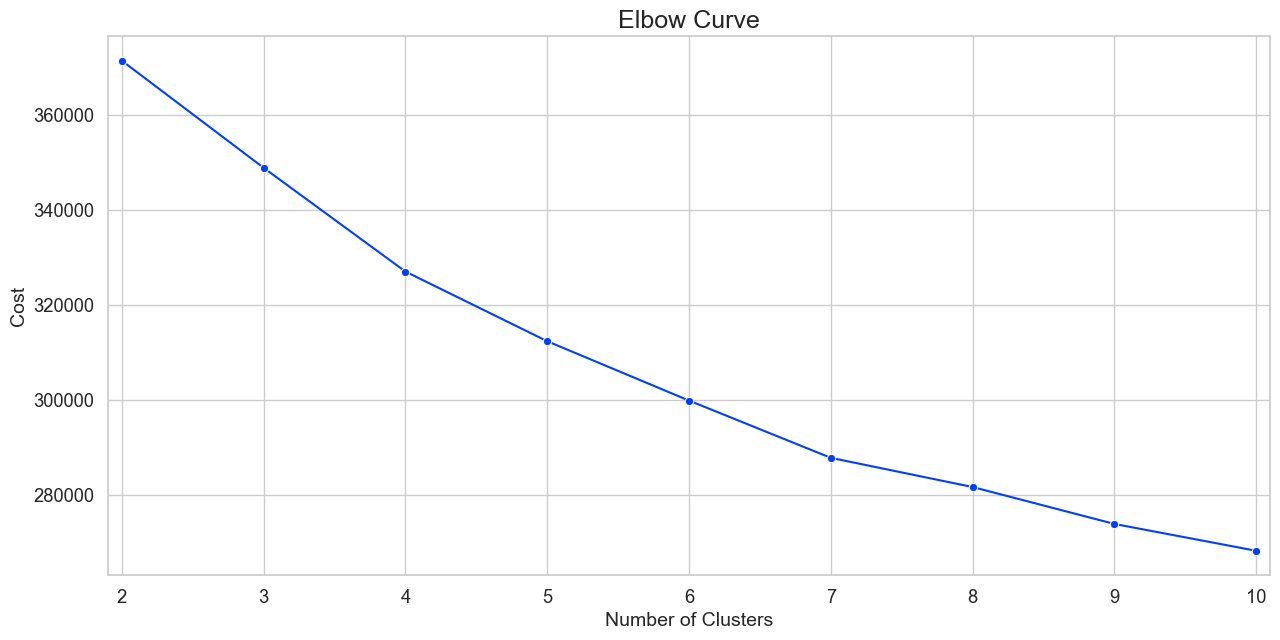

In [30]:
# Finding the optimal number of clusters by plotting the elbow curve
no_of_clusters = list(range(2, 11))
cost_values = []

for k in no_of_clusters:
    try:
        test_model = KPrototypes(n_clusters=k, init='Huang', random_state=42)
        test_model.fit_predict(train_array_sub, categorical=[3, 4])
        cost_values.append(test_model.cost_)
        successful_k = k
        
        print(f"Split the data in {k} clusters with cost: {test_model.cost_:.2f}")
    
    except ValueError as e:
        print(f"Too many clusters: {e}")
        break  # Stop the loop if ValueError is encountered

# Plotting the elbow curve for successfully processed clusters
sns.set_theme(style="whitegrid", palette="bright", font_scale=1.2)

plt.figure(figsize=(15, 7))
ax = sns.lineplot(x=no_of_clusters[:len(cost_values)], y=cost_values, marker="o", dashes=False)
ax.set_title('Elbow Curve', fontsize=18)
ax.set_xlabel('Number of Clusters', fontsize=14)
ax.set_ylabel('Cost', fontsize=14)
ax.set(xlim=(2 - 0.1, successful_k + 0.1))
plt.show()

In [31]:
# Cluster the entire dataset using the optimal number of clusters
model = KPrototypes(n_clusters=4, init='Huang', random_state=42, n_jobs=-1)
model.fit(train_array, categorical=[3,4])
test_labels = model.predict(test_array, categorical=[3,4])

#new column for cluster labels associated with each subject
X_trainval['Clusters'] = model.labels_
X_test['Clusters'] = test_labels

In [32]:
pd.set_option('display.max_columns', None)
X_trainval.head()

,PedPed,Barrier,CrossingSignal,AttributeLevel,NumberOfCharacters,DiffNumberOFCharacters,Man,Woman,Pregnant,Stroller,OldMan,OldWoman,Boy,Girl,Homeless,LargeWoman,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat,Finance_access,ICT,Industry_activity,Overall_index,Research_and_development,Skills,Total,Males,Females,Passengers,Pedestrians,NumberOfLivesSaved,Finance_nols,ICT_nols,Industry_nols,Overall_nols,Research_nols,Skills_nols,Total_nols,Males_nols,Females_nols,Passengers_nols,Pedestrians_nols,Clusters
826691,1,0,0,More,0.845076,-0.449067,1.894694,-0.436605,-0.437006,-0.437964,1.898027,-0.437596,-0.437237,-0.437748,-0.437297,-0.437018,4.223434,-0.437762,-0.437169,1.889421,-0.43736,-0.437544,-0.436515,-0.436645,-0.438072,-0.438222,0.807870,-0.203868,0.065141,1.001199,1.240847,0.192654,0.682665,0.514950,1.143918,0.438905,0.285340,2,0.797722,0.690334,0.730503,0.834899,0.952693,0.742719,0.880342,0.819175,1.033383,0.796188,0.721639,3
954580,0,0,0,More,0.845076,1.339690,-0.437400,-0.436605,-0.437006,-0.437964,-0.436789,-0.437596,1.894088,-0.437748,-0.437297,-0.437018,-0.436861,-0.437762,-0.437169,-0.438582,-0.43736,-0.437544,1.901005,4.225389,1.899310,-0.438222,0.807870,-0.203868,0.065141,1.001199,1.240847,0.192654,0.682665,0.514950,1.143918,0.438905,0.285340,4,1.595665,1.380825,1.461203,1.669956,1.905463,1.485694,1.760934,1.638626,2.066930,1.592638,1.443514,3
272253,1,0,2,Less,0.169392,-1.343446,-0.437400,-0.436605,-0.437006,-0.437964,-0.436789,1.894391,1.894088,-0.437748,1.900932,-0.437018,1.893286,-0.437762,-0.437169,-0.438582,-0.43736,-0.437544,-0.436515,-0.436645,-0.438072,-0.438222,-0.161656,0.996578,1.257895,0.269309,0.301359,0.192654,-0.946007,-0.896214,-1.005525,-0.851211,-0.946646,-1,-0.354861,-0.425073,-0.411214,-0.375934,-0.381186,-0.371744,-0.148188,-0.146033,-0.153415,-0.192520,-0.112154,0
749782,1,0,1,More,0.845076,0.445311,-0.437400,-0.436605,-0.437006,-0.437964,-0.436789,1.894391,1.894088,-0.437748,-0.437297,-0.437018,-0.436861,-0.437762,1.897445,-0.438582,-0.43736,-0.437544,1.901005,-0.436645,1.899310,-0.438222,0.807870,0.996578,0.065141,0.269309,-0.168385,0.192654,-0.632046,-0.675336,-0.457628,0.293474,-0.702728,3,1.196693,1.274595,1.095853,1.127169,1.000331,1.114207,0.612643,0.560944,0.737574,1.124759,0.483428,2
730754,1,0,1,More,0.845076,1.339690,1.894694,1.899724,-0.437006,-0.437964,-0.436789,-0.437596,-0.437237,-0.437748,-0.437297,4.223385,-0.436861,-0.437762,-0.437169,-0.438582,-0.43736,-0.437544,-0.436515,1.894372,-0.438072,-0.438222,-0.161656,0.196280,0.065141,-0.462581,-0.638128,-0.213274,-0.700725,-0.699878,-0.647285,-0.620939,-0.705261,4,1.418344,1.487054,1.461203,1.335933,1.143247,1.386631,0.767627,0.729655,0.855185,0.915828,0.642601,2


In [33]:
filtered_x_trainval = X_trainval.drop(columns=["AttributeLevel"])

pd.set_option('display.max_rows', None)
print(filtered_x_trainval.groupby('Clusters').agg(['median' ,'mean']).T)

Clusters                                0         1         2         3
PedPed                   median  0.000000  0.000000  0.000000  0.000000
                         mean    0.479947  0.481594  0.480041  0.480851
Barrier                  median  0.000000  0.000000  0.000000  0.000000
                         mean    0.259492  0.259644  0.261030  0.259631
CrossingSignal           median  0.000000  0.000000  0.000000  0.000000
                         mean    0.592327  0.594286  0.592047  0.593287
NumberOfCharacters       median -1.181976 -0.506292  0.845076  0.845076
                         mean   -0.845627 -0.837456  0.845075  0.845076
DiffNumberOFCharacters   median  0.445311 -0.449067 -0.449067  0.445311
                         mean    0.000099 -0.006592 -0.206466  0.337365
Man                      median -0.437400 -0.437400 -0.437400 -0.437400
                         mean   -0.146186 -0.146766  0.145378  0.148337
Woman                    median -0.436605 -0.436605 -0.436605 -0

In [34]:
# One-hot encode the columns 'AttributeLevel', 'ScenarioTypeStrict' and 'CrossingSignal' and change to integer

# Specify the columns to be one-hot encoded
onehot_columns = ['AttributeLevel', 'CrossingSignal', 'Clusters']

# Initialize the OneHotEncoder with drop='first' to avoid dummy variable trap and handle_unknown='ignore'
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

# Fit the encoder on the training set and transform the training data
X_trainval_encoded = encoder.fit_transform(X_trainval[onehot_columns])

# Transform the test set using the fitted encoder
X_test_encoded = encoder.transform(X_test[onehot_columns])

# Convert the one-hot encoded arrays to DataFrames with appropriate column names
encoded_columns = encoder.get_feature_names_out(onehot_columns)
df_trainval = pd.DataFrame(X_trainval_encoded, columns=encoded_columns, index=X_trainval.index)
df_test = pd.DataFrame(X_test_encoded, columns=encoded_columns, index=X_test.index)

# Drop the original one-hot encoded columns from the original DataFrames
X_trainval.drop(columns=onehot_columns, inplace=True)
X_test.drop(columns=onehot_columns, inplace=True)

# Concatenate the encoded columns with the rest of the original DataFrames
X_trainval = pd.concat([X_trainval, df_trainval], axis=1)
X_test = pd.concat([X_test, df_test], axis=1)

# Convert all one-hot encoded columns to integer type
onehot_encoded = df_trainval.columns.tolist()
X_trainval[onehot_encoded] = X_trainval[onehot_encoded].astype(int)
X_test[onehot_encoded] = X_test[onehot_encoded].astype(int)

In [36]:
# Change the data types to save memory
X_trainval[["AttributeLevel_More", "CrossingSignal_1", "CrossingSignal_2", "Clusters_1", "Clusters_2", "Clusters_3"]] = X_trainval[["AttributeLevel_More", "CrossingSignal_1", "CrossingSignal_2", "Clusters_1", "Clusters_2", "Clusters_3"]].astype(float).round().astype('int8')
X_test[["AttributeLevel_More", "CrossingSignal_1", "CrossingSignal_2", "Clusters_1", "Clusters_2", "Clusters_3"]] = X_test[["AttributeLevel_More", "CrossingSignal_1", "CrossingSignal_2", "Clusters_1", "Clusters_2", "Clusters_3"]].astype(float).round().astype('int8')

y_trainval = y_trainval.astype('int8')
y_test = y_test.astype('int8')

In [40]:
# Save X_trainval, X_test, y_trainval and y_test to CSV files
X_trainval.to_csv('Data/X_trainval_utilitarian.csv', index=False)
X_test.to_csv('Data/X_test_utilitarian.csv', index=False)
y_trainval.to_csv('Data/y_trainval_utilitarian.csv', index=False)
y_test.to_csv('Data/y_test_utilitarian.csv', index=False)